In [1]:
from ortools.sat.python import cp_model
from itertools import permutations, combinations
import time
import os
import pandas as pd
import random


In [2]:

def parse_jssp_file(filename):
    jobs_data = []

    with open(filename, "r") as f:
        lines = [
            line.strip()
            for line in f
            if line.strip() and not line.strip().startswith("#")
        ]

    num_jobs, num_machines = map(int, lines[0].split())

    for i in range(1, num_jobs + 1):
        data = list(map(int, lines[i].split()))
        job = []

        for k in range(0, len(data), 2):
            machine = data[k]
            duration = data[k + 1]
            job.append((machine, duration))

        jobs_data.append(job)

    return jobs_data, num_jobs, num_machines



In [3]:
jobs_data, num_jobs, num_machines = parse_jssp_file("../data/instances_jsp/la21.txt")

In [ ]:
def greedy_initial_schedule(jobs_data, num_jobs, num_machines):
    """
    Génère un planning initial faisable.
    Respecte :
      - ordre des tâches dans chaque job
      - une tâche à la fois par machine
    """
    start_times = {}
    machine_next_free = [0] * num_machines
    job_next_free = [0] * num_jobs

    for j, job in enumerate(jobs_data):
        for t, (m, d) in enumerate(job):
            est = max(machine_next_free[m], job_next_free[j])
            start_times[(j, t)] = est
            machine_next_free[m] = est + d
            job_next_free[j] = est + d

    return start_times




def random_initial_schedule(jobs_data, num_machines):
    """
    Génère une solution initiale faisable aléatoire
    (ordre aléatoire des tâches sur chaque machine)
    """
    machine_tasks = [[] for _ in range(num_machines)]

    # Affecter chaque tâche à sa machine
    for j, job in enumerate(jobs_data):
        for t, (m, _) in enumerate(job):
            machine_tasks[m].append((j, t))

    for m in range(num_machines):
        random.shuffle(machine_tasks[m])

    machine_next_free = [0] * num_machines
    job_next_free = [0] * len(jobs_data)
    schedule = {}

    for m in range(num_machines):
        for (j, t) in machine_tasks[m]:
            dur = jobs_data[j][t][1]
            est = max(machine_next_free[m], job_next_free[j])
            schedule[(j, t)] = est
            machine_next_free[m] = est + dur
            job_next_free[j] = est + dur

    return schedule



In [6]:
import copy

def makespan_of_schedule(jobs_data, schedule):
    """Calcule le makespan d'un planning donné.
    schedule[(j,t)] = start time"""
    end_times = {}
    machine_end = {}
    for j, job in enumerate(jobs_data):
        for t, (m, d) in enumerate(job):
            s = schedule[(j, t)]
            e = s + d
            end_times[(j, t)] = e
            machine_end[m] = max(machine_end.get(m, 0), e)
    return max(end_times.values())


In [ ]:
def reconstruct_schedule(task_order, jobs_data, num_machines):
    """
    Reconstruit un planning faisable (start times)
    à partir d'un ordre global de tâches
    """
    machine_next_free = [0] * num_machines
    job_next_free = [0] * len(jobs_data)
    schedule = {}

    for (j, t) in task_order:
        m, dur = jobs_data[j][t]
        est = max(machine_next_free[m], job_next_free[j])
        schedule[(j, t)] = est
        machine_next_free[m] = est + dur
        job_next_free[j] = est + dur

    return schedule


def reconstruct_schedule_for_all_machines(new_order, machine_tasks, m_changed, jobs_data, num_machines):
    """
    Reconstruit les start times gloutonnement pour toutes les machines,
    en utilisant l'ordre modifié pour la machine m_changed
    """
    machine_next_free = [0]*num_machines
    job_next_free = [0]*len(jobs_data)
    schedule = {}

    for m in range(num_machines):
        order = new_order if m == m_changed else machine_tasks[m]
        for (j, t) in order:
            dur = jobs_data[j][t][1]
            est = max(machine_next_free[m], job_next_free[j])
            schedule[(j,t)] = est
            machine_next_free[m] = est + dur
            job_next_free[j] = est + dur
    return schedule




def generate_sample_neighbors(schedule, jobs_data, num_machines, sample_size=50):
    """
    Au lieu de tout générer, on tire 'sample_size' voisins au hasard.
    Permet de traiter des instances géantes sans bloquer le CPU.
    """
    neighbors = []
    
    sorted_items = sorted(schedule.items(), key=lambda x: x[1])
    machine_tasks = [[] for _ in range(num_machines)]
    for (j, t), start in sorted_items:
        m = jobs_data[j][t][0]
        machine_tasks[m].append((j, t))

    attempts = 0
    while len(neighbors) < sample_size and attempts < sample_size * 5:
        attempts += 1
        
        m = random.randint(0, num_machines - 1)
        tasks = machine_tasks[m]
        
        if len(tasks) < 2: continue

        idx1, idx2 = random.sample(range(len(tasks)), 2)
        
        new_order = tasks[:]
        new_order[idx1], new_order[idx2] = new_order[idx2], new_order[idx1]
        
        neighbor_sol = reconstruct_schedule_for_all_machines(new_order, machine_tasks, m, jobs_data, num_machines)
        
        neighbors.append(neighbor_sol)

    return neighbors



In [14]:
def greedy_local_search_best_improvement_full(jobs_data, num_machines, max_time=10, min_makespan=None, random=False):
    start_time = time.time()
    if not random:
        current = greedy_initial_schedule(jobs_data, len(jobs_data), num_machines)
    else : 
        current = random_initial_schedule(jobs_data, num_machines)
    current_mk = makespan_of_schedule(jobs_data, current)

    while True:
        if time.time() - start_time > max_time:
            break
        if min_makespan is not None and current_mk <= min_makespan:
            break

        neighbors = generate_sample_neighbors(current, jobs_data, num_machines, 50)

        # Choisir le meilleur voisin
        best_neighbor = None
        best_mk = current_mk
        for neighbor in neighbors:
            mk = makespan_of_schedule(jobs_data, neighbor)
            if mk < best_mk:
                best_mk = mk
                best_neighbor = neighbor

        if best_neighbor is not None:
            current = best_neighbor
            current_mk = best_mk
        else:
            break  # plateau / optimum local

    elapsed = time.time() - start_time
    return current, current_mk, elapsed


In [15]:
import random
import time
import copy

def random_walk_jsp(
    jobs_data,
    num_machines,
    max_time=10,
    min_makespan=None,
    pnoise=0.05,
    max_no_improve=300
):
    """
    Random Walk avec stagnation
    - max_time : temps max
    - min_makespan : seuil objectif
    - pnoise : diversification
    - max_no_improve : nb max de pas sans amélioration
    """

    start_time = time.time()

    # Solution initiale gloutonne
    current = greedy_initial_schedule(jobs_data, len(jobs_data), num_machines)
    current_mk = makespan_of_schedule(jobs_data, current)

    best_solution = current.copy()
    best_mk = current_mk

    no_improve = 0

    while True:
        elapsed = time.time() - start_time

        # --- Critères d'arrêt ---
        if elapsed >= max_time:
            break
        if min_makespan is not None and best_mk <= min_makespan:
            break
        if no_improve >= max_no_improve:
            break

        # Générer le voisinage
        neighbors = generate_sample_neighbors(current, jobs_data, num_machines)
        if not neighbors:
            break

        # Diversification / intensification
        if random.random() < pnoise:
            next_solution = random.choice(neighbors)
        else:
            next_solution = min(
                neighbors,
                key=lambda s: makespan_of_schedule(jobs_data, s)
            )

        next_mk = makespan_of_schedule(jobs_data, next_solution)

        # Acceptation (random walk)
        current = next_solution
        current_mk = next_mk

        # Mise à jour du meilleur
        # print(f"current mk : {current_mk} , best_mk : {best_mk}")
        if current_mk < best_mk:
            best_solution = current.copy()
            best_mk = current_mk
            no_improve = 0  
        else:
            no_improve += 1

        # print(f"nb improve : {no_improve}")

    elapsed = time.time() - start_time
    return best_solution, best_mk, elapsed


In [16]:
import random
import time
import math
import copy

def simulated_annealing_jsp(jobs_data, num_machines, 
                             schedule_init=None,
                             T_init=1000.0, T_min=1e-3, cooling_rate=0.95, 
                             max_time=10, min_makespan=None):
    """
    Simulated Annealing pour le JSP
    
    jobs_data : données du problème
    num_machines : nombre de machines
    schedule_init : solution initiale (si None, on construit gloutonnement)
    T_init : température initiale
    T_min : température minimale pour arrêter
    cooling_rate : taux de décroissance de T par itération (0 < cooling_rate < 1)
    max_time : temps limite en secondes
    min_makespan : seuil minimal pour arrêter
    """
    start_time = time.time()

    # Solution initiale
    if schedule_init is None:
        current = greedy_initial_schedule(jobs_data, len(jobs_data), num_machines)
    else:
        current = schedule_init.copy()
    
    current_mk = makespan_of_schedule(jobs_data, current)
    best_solution = current.copy()
    best_mk = current_mk

    T = T_init

    while T > T_min:
        elapsed = time.time() - start_time
        if elapsed > max_time:
            break
        if min_makespan is not None and best_mk <= min_makespan:
            break

        # Générer un voisin aléatoire
        neighbors = generate_sample_neighbors(current, jobs_data, num_machines)
        if not neighbors:
            break
        neighbor = random.choice(neighbors)
        neighbor_mk = makespan_of_schedule(jobs_data, neighbor)

        delta = neighbor_mk - current_mk  # différence de coût

        # Critère d'acceptation
        if delta <= 0:
            # Meilleur voisin → toujours accepté
            accept = True
        else:
            # Voisin moins bon → accepté avec probabilité e^(-delta/T)
            prob = math.exp(-delta / T)
            accept = random.random() < prob

        if accept:
            current = neighbor
            current_mk = neighbor_mk

            # Mettre à jour la meilleure solution trouvée
            if current_mk < best_mk:
                best_solution = current.copy()
                best_mk = current_mk

        # Refroidissement
        T *= cooling_rate

    elapsed = time.time() - start_time
    return best_solution, best_mk, elapsed


In [20]:
num_jobs = len(jobs_data)
num_machines = max(m for job in jobs_data for m, _ in job) + 1  # vrai nombre de machines

schedule, mk, t = greedy_local_search_best_improvement_full(
    jobs_data,
    num_machines=num_machines,
    max_time=5,         # stop après 5s
    min_makespan=1450,    # stop si makespan <= 1450
    random=False
)

print(f"Makespan trouvé : {mk}, Temps écoulé : {t:.2f}s")


Makespan trouvé : 1695, Temps écoulé : 0.01s


In [21]:
num_machines = max(m for job in jobs_data for m, _ in job) + 1

schedule_rw, mk_rw, t_rw = random_walk_jsp(
    jobs_data,
    num_machines=num_machines,
    max_time=10,
    min_makespan=1450,
    max_no_improve=50,
    pnoise=0.7 
)

print(f"Makespan Random Walk : {mk_rw}, Temps écoulé : {t_rw:.2f}s")


Makespan Random Walk : 1751, Temps écoulé : 0.25s


In [22]:
num_machines = max(m for job in jobs_data for m, _ in job) + 1

schedule, mk, t = random_walk_jsp(
    jobs_data,
    num_machines=num_machines,
    max_time=10,         # limite à 5 secondes
    min_makespan=1450    # stop si seuil atteint
)

print(f"Makespan : {mk}, Temps écoulé : {t:.2f}s")


Makespan : 1695, Temps écoulé : 1.76s


In [26]:
mk_somme = 0
TOTAL = 20
mk_min = 10000

for _ in range(0,TOTAL-1) : 
    _, mk, _ = random_walk_jsp(
    jobs_data,
    num_machines=num_machines,
    max_time=1,         # limite à 5 secondes
    min_makespan=1450    # stop si seuil atteint
    )

    mk_somme += mk 
    if mk < mk_min : 
        mk_min = mk



print(f"Makespan min : {mk_min}, Makespan moyen : {mk_somme / (TOTAL - 1)}")


Makespan min : 1695, Makespan moyen : 1695.0


In [27]:
num_machines = max(m for job in jobs_data for m, _ in job) + 1

schedule_sa, mk_sa, t_sa = simulated_annealing_jsp(
    jobs_data,
    num_machines=num_machines,
    T_init=2000,
    T_min=1e-2,
    cooling_rate=0.90,
    max_time=10,
    min_makespan=1450
)

print(f"Makespan Simulated Annealing : {mk_sa}, Temps écoulé : {t_sa:.2f}s")


Makespan Simulated Annealing : 1726, Temps écoulé : 0.38s


In [ ]:
def benchmark_jsp(instances_folder, max_time=10, min_makespan=None, pnoise=0.05):
    """
    Benchmark Greedy classique, Greedy random, Random Walk et Simulated Annealing
    """
    results = []

    instance_files = [f for f in os.listdir(instances_folder) if f.endswith(".txt")]
    instance_files.sort()

    for file in instance_files:
        filepath = os.path.join(instances_folder, file)
        jobs_data, num_jobs, num_machines = parse_jssp_file(filepath)

        print(f"Instance : {file} ({num_jobs} jobs, {num_machines} machines)")

        # Greedy classique (départ glouton)
        start = time.time()
        schedule_greedy, mk_greedy, _ = greedy_local_search_best_improvement_full(
            jobs_data, num_machines,
            max_time=max_time,
            min_makespan=min_makespan,
            random=False
        )
        t_greedy = time.time() - start

        # Greedy aléatoire (départ random)
        start = time.time()
        schedule_greedy_random, mk_greedy_random, _ = greedy_local_search_best_improvement_full(
            jobs_data, num_machines,
            max_time=max_time,
            min_makespan=min_makespan,
            random=True
        )
        t_greedy_random = time.time() - start

        # Random Walk
        schedule_rw, mk_rw, t_rw = random_walk_jsp(
            jobs_data, num_machines,
            max_time=max_time,
            min_makespan=min_makespan,
            pnoise=pnoise,
            max_no_improve=75
        )

        # Simulated Annealing
        schedule_sa, mk_sa, t_sa = simulated_annealing_jsp(
            jobs_data, num_machines, schedule_init=None,
            T_init=1000, T_min=1e-2, cooling_rate=0.95,
            max_time=max_time, min_makespan=min_makespan
        )

        results.append({
            "instance": file,
            "greedy_makespan": mk_greedy,
            "greedy_time": t_greedy,
            "greedy_random_makespan": mk_greedy_random,
            "greedy_random_time": t_greedy_random,
            "random_walk_makespan": mk_rw,
            "random_walk_time": t_rw,
            "simulated_annealing_makespan": mk_sa,
            "simulated_annealing_time": t_sa
        })

    return pd.DataFrame(results)

In [ ]:
df_results = benchmark_jsp("../data/instances_jsp", max_time=10, min_makespan=None, pnoise=0.4)
print(df_results)


Instance : abz5.txt (10 jobs, 10 machines)
Instance : abz6.txt (10 jobs, 10 machines)
Instance : abz7.txt (20 jobs, 15 machines)
Instance : abz8.txt (20 jobs, 15 machines)
Instance : abz9.txt (20 jobs, 15 machines)
Instance : ft06.txt (6 jobs, 6 machines)
Instance : ft10.txt (10 jobs, 10 machines)
Instance : la01.txt (10 jobs, 5 machines)
Instance : la02.txt (10 jobs, 5 machines)
Instance : la03.txt (10 jobs, 5 machines)
Instance : la04.txt (10 jobs, 5 machines)
Instance : la05.txt (10 jobs, 5 machines)
Instance : la06.txt (15 jobs, 5 machines)
Instance : la07.txt (15 jobs, 5 machines)
Instance : la08.txt (15 jobs, 5 machines)
Instance : la09.txt (15 jobs, 5 machines)
Instance : la10.txt (15 jobs, 5 machines)
Instance : la11.txt (20 jobs, 5 machines)
Instance : la12.txt (20 jobs, 5 machines)
Instance : la13.txt (20 jobs, 5 machines)
Instance : la14.txt (20 jobs, 5 machines)
Instance : la15.txt (20 jobs, 5 machines)
Instance : la16.txt (10 jobs, 10 machines)
Instance : la17.txt (10 jobs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_jsp_comparison(df_results):
    instances = df_results["instance"]
    x = np.arange(len(instances))

    # -----------------------------
    # Makespan comparatif
    # -----------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(x, df_results["greedy_makespan"], marker='o', label="Greedy classique")
    plt.plot(x, df_results["greedy_random_makespan"], marker='d', label="Greedy random")
    plt.plot(x, df_results["random_walk_makespan"], marker='s', label="Random Walk")
    plt.plot(x, df_results["simulated_annealing_makespan"], marker='^', label="Simulated Annealing")
    plt.xticks(x, instances, rotation=45, ha='right')
    plt.ylabel("Makespan")
    plt.xlabel("Instance")
    plt.ylim(0, 10000)
    plt.title("Comparaison des Makespans pour chaque instance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Temps d'exécution comparatif
    # -----------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(x, df_results["greedy_time"], marker='o', label="Greedy classique")
    plt.plot(x, df_results["greedy_random_time"], marker='d', label="Greedy random")
    plt.plot(x, df_results["random_walk_time"], marker='s', label="Random Walk")
    plt.plot(x, df_results["simulated_annealing_time"], marker='^', label="Simulated Annealing")
    plt.xticks(x, instances, rotation=45, ha='right')
    plt.ylabel("Temps d'exécution (s)")
    plt.xlabel("Instance")
    plt.title("Comparaison des temps d'exécution pour chaque instance")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



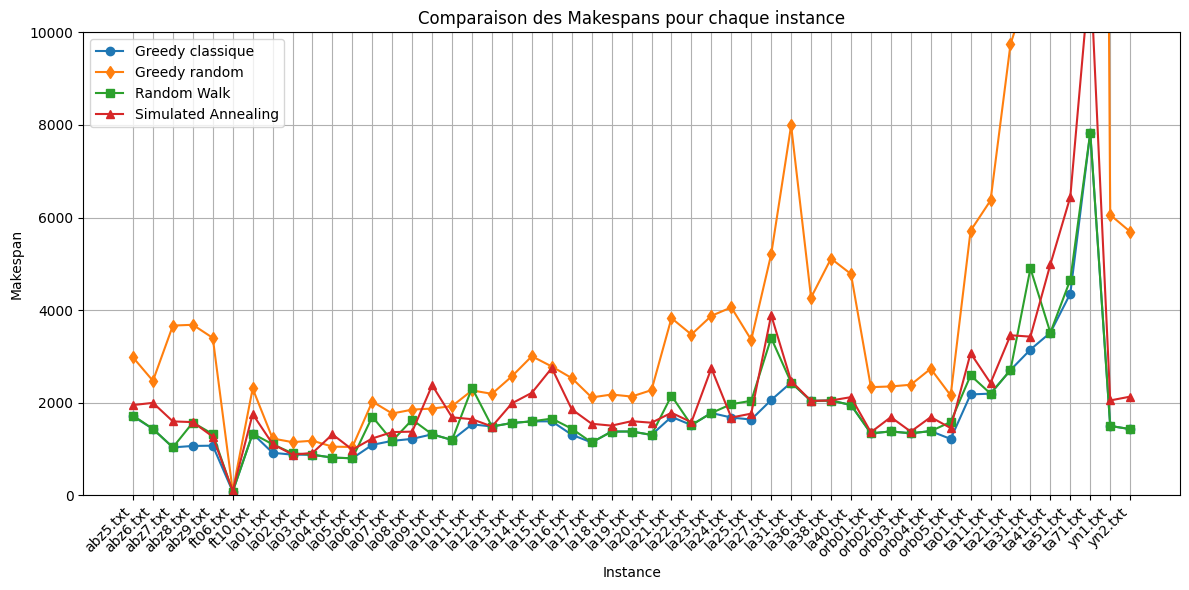

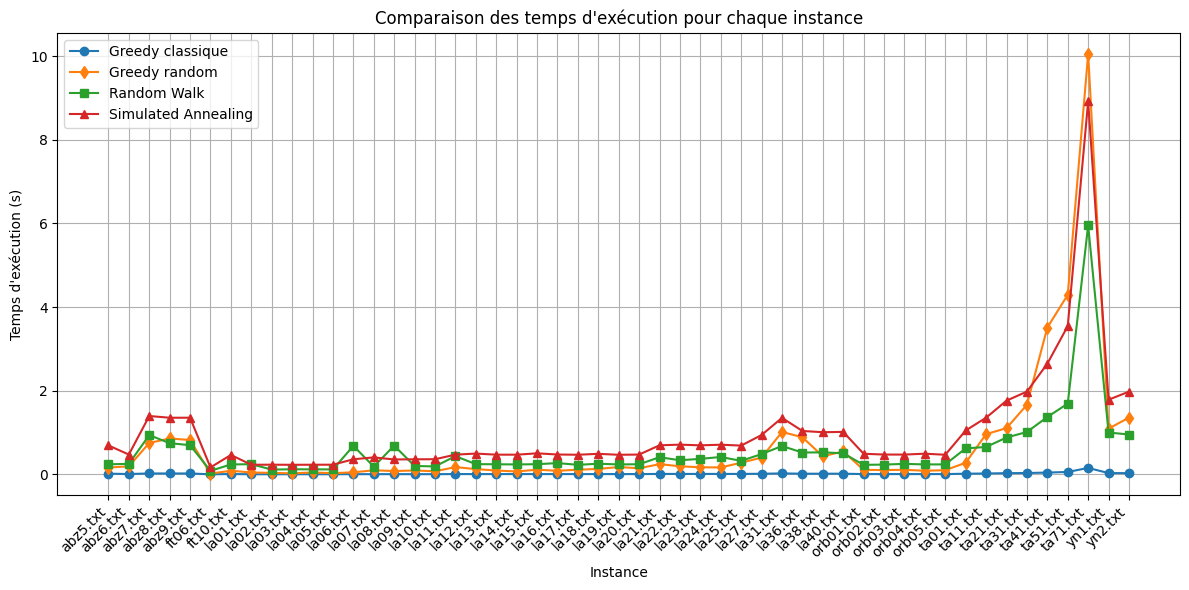

In [36]:
# df_results : résultat de benchmark_jsp
plot_jsp_comparison(df_results)


In [ ]:
print(df_results.columns)

Index(['instance', 'greedy_makespan', 'greedy_time', 'greedy_random_makespan',
       'greedy_random_time', 'random_walk_makespan', 'random_walk_time',
       'simulated_annealing_makespan', 'simulated_annealing_time'],
      dtype='object')


In [72]:
print(df_results[["instance", "greedy_makespan"]])


   instance  greedy_makespan
0  abz5.txt             1707
1  abz6.txt             1433
2  ft06.txt               80
3  ft10.txt             1332
4  la01.txt              918
5  la11.txt             1533
6  la16.txt             1308
7  la21.txt             1695
8  la31.txt             2435


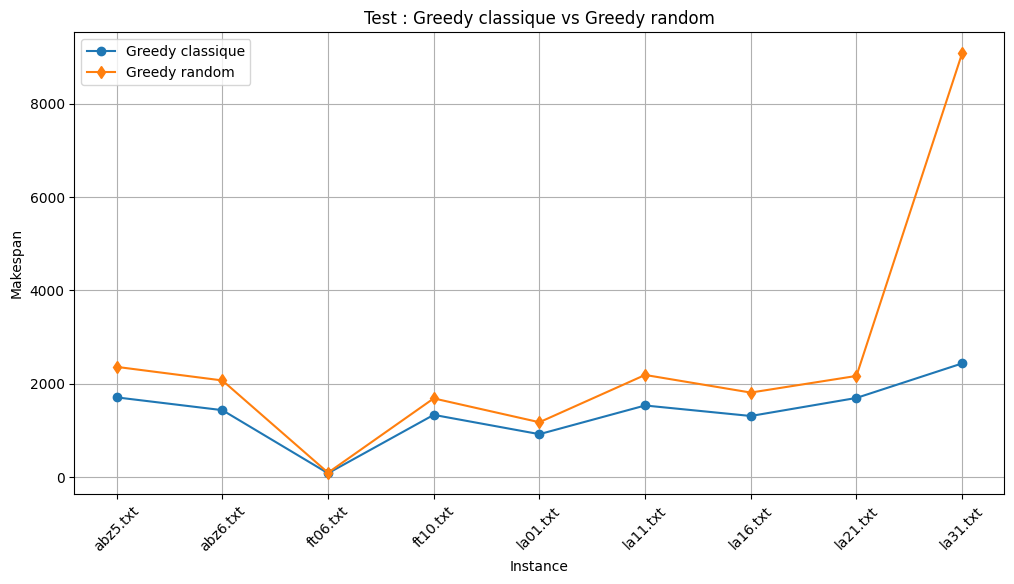

In [73]:
plt.figure(figsize=(12,6))
plt.plot(df_results["instance"], df_results["greedy_makespan"], marker='o', label="Greedy classique")
plt.plot(df_results["instance"], df_results["greedy_random_makespan"], marker='d', label="Greedy random")
plt.xticks(rotation=45)
plt.ylabel("Makespan")
plt.xlabel("Instance")
plt.title("Test : Greedy classique vs Greedy random")
plt.legend()
plt.grid(True)
plt.show()
